**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 11: Mixture models and density estimation

**Content:**
- Part 1: The Gaussian Mixture Model and the EM algorithm
- Part 2: Gaussian mixture models and model selection
- Part 3: Density estimation
- Part 4: Outlier detection 
- Part 5: Outlier detection on hand written digits


**Objectives:**
- Understand how the expectation-maximization is used to estimate the model parameters in the Gaussian mixture model.
- Understand how information criteria and cross-validation is used to choose the number of clusters in the Gaussian mixture model.
- Understand how the density of data can be estimated by histograms, Gaussian mixture models, kernel density estimators and $k$-nearest neighbor density estimation, 
- Understand density based and distance based outlier/anomaly detection methods.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

def gauss_2d(centroid, ccov, std=2, points=100):
    """
    Returns two vectors representing slice through gaussian, cut at given standard deviation.

    Parameters:
    centroid (array-like): The centroid of the Gaussian distribution.
    ccov (array-like): The covariance matrix of the Gaussian distribution.
    std (float, optional): The standard deviation at which to cut the Gaussian distribution. Default is 2.
    points (int, optional): The number of points to sample along the slice. Default is 100.

    Returns:
    tuple: A tuple containing two vectors representing the slice through the Gaussian distribution.
    """
    mean = np.c_[centroid]
    tt = np.c_[np.linspace(0, 2 * np.pi, points)]
    x = np.cos(tt)
    y = np.sin(tt)
    ap = np.concatenate((x, y), axis=1).T
    d, v = np.linalg.eig(ccov)
    d = std * np.sqrt(np.diag(d))
    bp = np.dot(v, np.dot(d, ap)) + np.tile(mean, (1, ap.shape[1]))
    return bp[0, :], bp[1, :]

def clusterplot(X, clusterid=None, centroids=None, y=None, covariances=None):
    for i, pred_class in enumerate(np.unique(clusterid)):
        mask = (clusterid == pred_class)
        plt.scatter(X[mask, 0], X[mask, 1], s=100, facecolors=f'C{i}', label=f'Predicted class {pred_class}', linewidth=5)

    for i, true_class in enumerate(np.unique(y)):
        mask = (y == true_class)
        plt.scatter(X[mask, 0], X[mask, 1], s=50, c=f"C{i}", edgecolors='k', label=f'True class {true_class}')

    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')

    if covariances is not None:
        for i in range(len(centroids)):
            x1, x2 = gauss_2d(centroids[i], covariances[i])
            plt.plot(x1, x2, "-", color=f'C{i}', linewidth=3)

    plt.title("Cluster Plot")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(ncols=2)


---
## Introduction

In this exercise, we introduce key methods for modeling and estimating probability densities from data. This includes the Gaussian Mixture Model (GMM), kernel density estimation (KDE), and $k$-nearest neighbors (kNN) density estimation to understand how different approaches approximate underlying distributions. We will apply these techniques to do clustering based on the GMM and identify outliers, highlighting the practical use of density estimation in detecting unusual or rare data points and try it out on the image data that we previously considered.


---
## Part 1: The Gaussian Mixture Model and the EM algorithm

We recall that the multivariate Gaussian distribution is given by
$$
  \mathcal{N}(\boldsymbol{x}_{i}|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})=\frac{1}{\sqrt{\mathrm{det}(2\pi\boldsymbol{\Sigma}_{(k)})}}\mathrm{exp}\big\{-\tfrac12(\boldsymbol{x}_i-\boldsymbol{\mu}_{(k)})^\top\boldsymbol{\Sigma}_{(k)}^{-1}(\boldsymbol{x}_i-\boldsymbol{\mu}_{(k)})\big\}.
$$

In the Gaussian mixture model we use a mixture of $K$ multivariate Gaussians to model the data. We give each Gaussian a mixture coefficient $w_k$ between zero and one such that all coefficients sum to one, $\sum_{k=1}^{K}w_k=1$. The probability of a data vector $\boldsymbol{x}_i$ is then modeled as a weighted sum of Gaussian distributions,
$$
  p(\boldsymbol{x}_i|\boldsymbol{w},\{(\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)}),\ldots ,(\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)}) \})=\sum_{k=1}^K w_k\cdot\mathcal{N}(\boldsymbol{x}_{i}|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})
$$
The parameters of the model, which comprises the mixture coefficients and the $K$ means and covariance matrices, are found by the Expectation-Maximization (EM) algorithm that progress in the following way:
- Initialize the mixture coefficient $\boldsymbol{w}$, mean and covariance of each Gaussian $\boldsymbol{\mu}_{(k)}$ and $\boldsymbol{\Sigma}_{(k)}$ by random.
- (E-step) Calculate the expectation $P(k| \boldsymbol{x}_i,\boldsymbol{w},\{(\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)}),\ldots,(\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)})\})$ for each data point.
- (M-step) Optimize $\boldsymbol{w}$ and $\{(\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)}),\ldots ,(\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)}) \}$ by maximizing the expected likelihood.
- Keep doing 2 and 3 until the clusters do not change or a maximum number of iterations have progressed.

The EM-algorithm is closely related to the $k$-means algorithm but rather than operating with hard assignment of each data point, each data point is assigned a given probability of belonging to each cluster based on Bayes rule,
$$
  \text{(E-step)} \qquad P(k|\boldsymbol{x}_i,\boldsymbol{w},\{(\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)}),\ldots ,(\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)}) \})=\frac{w_k\cdot \mathcal{N}(\boldsymbol{x}_i|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})}{\sum_{k=1}^K w_k\cdot \mathcal{N}(\boldsymbol{x}_i|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})}, 
$$
while each cluster is not only described by its center (mean) but also by its covariance. We call this quantity the *responsibilities*. In order to get hard assignments of the data points from the results obtained by the above EM-algorithm we assign the observations to the clusters with highest probability.

An important property of the estimated Gaussian mixture model is that the GMM density integrates to one, i.e.
$$
  \int\sum_k w_k\cdot\mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})d\boldsymbol{x}=\sum_k w_k\int\mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})d\boldsymbol{x}=1
$$
This follows from the fact that each Gaussian integrates to one $\int\mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu}_{(k)},\boldsymbol{\Sigma}_{(k)})d\boldsymbol{x}=1$ and the constraint $\sum_{k=1}^{K}w_k=1$. An important consequence of this is that when additional clusters are introduced they have to take density mass from existing clusters.

For a Gaussian mixture model, the parameter updates in the maximization step (M-step) have closed forms (as seen in the lecture). Specifically, the update equations are:

$$
\begin{align*}
  N_k &= \sum_{n=1}^N p(k \mid \boldsymbol{x}_n) \\
  w_k &= \frac{N_k}{N} \\
  \mu_{(k)} &= \frac{1}{N_k} \sum_{n=1}^N \boldsymbol{x}_n \, p(k \mid \boldsymbol{x}_n) \\
  \Sigma_{(k)} &= \frac{1}{N_k} \sum_{n=1}^N (\boldsymbol{x}_n - \mu_{(k)})(\boldsymbol{x}_n - \mu_{(k)})^\top \, p(k \mid \boldsymbol{x}_n)
\end{align*}
$$

**Task 1.1:** Generate a dataset of $N=90$ points from a Gaussian mixture model of the form $p(x) = \frac{1}{3}{\cal N}(x|1,1) + \frac{1}{3}{\cal N}(x|3,0.25) + \frac{1}{3}{\cal N}(x|6,4)$.

> *Hint:* First, identify the GMM parameters, that is the weight, mean and standard deviation per component. Remember that a Gaussian is given by $\mathcal{N}(\mu, \sigma^2)$.

> *Hint:* Use the weights to determine how many points to sample from each component.

> *Hint:* For each component, sample that many points from the correct Gaussian and fill the values in the X data matrix, e.g. using `X[start_idx:end_idx] = np.random.randn(Nk[k]) * sigmas[k] + mus[k]`.

> *Hint:* We visualize the *true components* by evaluating `scipy.stats.norm` over a fine grid of input points.

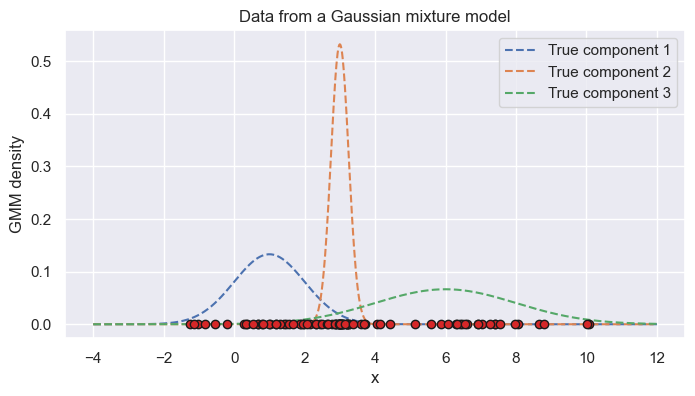

In [7]:
from scipy.stats import norm

N = 90

# Set random seed for reproducibility
np.random.seed(1234)

# Define the parameters of the GMM: weights, means, and standard_deviations and Nk (number of samples) for each component
K = 3
weights = np.array([1/3, 1/3, 1/3])
Nk = (weights * N).astype(int)
means = np.array([1, 3, 6])
standard_deviations = np.array([1.0, 0.25, 2.0])


# Generate synthetic data
X = np.zeros((Nk.sum()))
for k in range(K):
    # Determine the slice of X to fill for component k
    start_idx = Nk[:k].sum()
    end_idx = start_idx + Nk[k]

    # Generate data for component k and fill the appropriate slice of X
    X[start_idx:end_idx] = np.random.randn(Nk[k]) * standard_deviations[k] + means[k]
    

# Visualize the data and the true component densities
plt.figure(figsize=(8, 4))

# Plot the true component densities
x = np.linspace(-4, 12, 1000) # x grid to evaluate the densities on
for k in range(K):
    plt.plot(x, weights[k] * norm.pdf(x, means[k], standard_deviations[k]), '--', label=f'True component {k+1}')

# Plot the data points
plt.plot(X, np.zeros_like(X), 'o', color='tab:red', mec='k')
# Add labels and legend
plt.title('Data from a Gaussian mixture model')
plt.xlabel('x')
plt.ylabel('GMM density')
plt.legend()
plt.show()

**Task 1.2:** Implement the missing parts of the EM algorithm using $K=2$ components.

> *Hint:* Remember that you can compute the likelihood $\mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_{(k)}, \mathbf{\Sigma}_{(k)})$ using `scipy.stats.norm.pdf(X, means[k], standard_deviations[k])`.

> *Hint:* You need to compute the component-wise likelihoods, that is `component_wise_likelihoods[:, k] = gmm_weights[k] * norm.pdf(X, gmm_means[k], gmm_standard_deviations[k])`.

> *Hint:* We show you how to update the standard deviations of the GMM components (part of the M-step). Fill in the remaining for the means and weights.

Converged at iteration 61
Estimated means: [7.11570125 1.69422215 3.04629604]
Estimated variances: [1.35006596 1.47314475 0.12648638]
Estimated weights: [0.25897038 0.51355325 0.22747637]


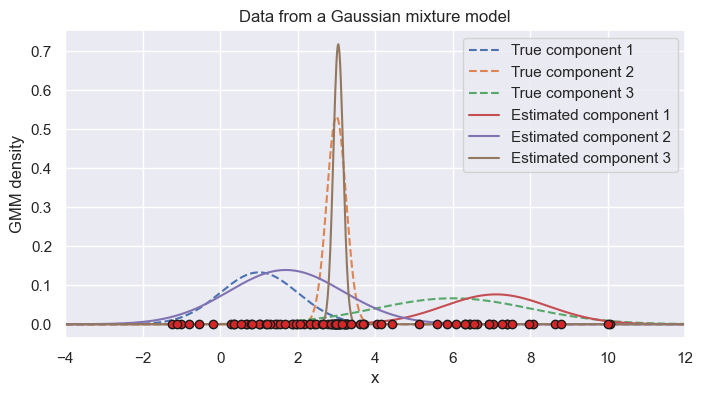

In [8]:
# Number of components to learn
K = 3

# Define convergence parameters of the EM algorithm
max_iter = 1000
tol = 1e-6

# Randomly initialize means, variances, and weights
gmm_means = np.random.choice(X, K) # Randomly choose K data points as initial means
gmm_standard_deviations = np.random.uniform(0.5, 2.0, K) # Random standard deviations between 0.5 and 2.0
# Initialize weights - must sum to 1
gmm_weights = np.random.rand((K))
gmm_weights = gmm_weights / gmm_weights.sum()

# Log likelihood initialization
log_likelihood_old = -np.inf

# EM algorithm for 1D Gaussian Mixture Model (GMM) with K components
for iteration in range(max_iter):
    
    # E-step: compute the probability of the expectation step for each mixture component. Let's call these "responsibilities"
    
    # Setup the component-wise likelihood matrix (points x components)
    component_wise_likelihoods = np.zeros((N, K))
    for k in range(K):
        # Compute the component-wise-likelihoods using the current parameters of the GMM
        component_wise_likelihoods[:, k] = gmm_weights[k] * norm.pdf(X, gmm_means[k], gmm_standard_deviations[k])

    # Compute the responsibilities for each component from Bayes rule (i.e. the component-wise likelihoods divided by the sum of component-wise likelihoods)
    responsibilities = component_wise_likelihoods / component_wise_likelihoods.sum(axis=1, keepdims=True)

    # M-step: update parameters
    # We provide an example for updating the GMM standard deviations, you need to fill in the updates for the means and weights. Use the formulas presented above.
    gmm_standard_deviations = np.sqrt((responsibilities * (X[:, None] - gmm_means)**2).sum(axis=0) / Nk)
    Nk = responsibilities.sum(axis=0)
    gmm_weights = Nk / N
    gmm_means = (responsibilities * X[:, None]).sum(axis=0) / Nk

    # Check for convergence
    log_likelihood = np.sum(np.log(component_wise_likelihoods.sum(axis=1)))
    if np.abs(log_likelihood - log_likelihood_old) < tol:
        print(f'Converged at iteration {iteration}')
        break

    # Update log likelihood for convergence check in next iteration
    log_likelihood_old = log_likelihood

# Print the estimated parameters
print("Estimated means:", gmm_means)
print("Estimated variances:", gmm_standard_deviations)
print("Estimated weights:", gmm_weights)



# Plot the data
plt.figure(figsize=(8, 4))
x = np.linspace(-4, 12, 1000) # x grid to evaluate the densities on

# Plot the true component densities
for k in range(K):
    plt.plot(x, weights[k] * norm.pdf(x, means[k], standard_deviations[k]), '--', label=f'True component {k+1}')

# Plot the estimated component densities
for k in range(K):
    plt.plot(x, gmm_weights[k] * norm.pdf(x, gmm_means[k], gmm_standard_deviations[k]), '-', label=f'Estimated component {k+1}')

# Plot the data points
plt.plot(X, np.zeros_like(X), 'o', color='tab:red', mec='k')
# Add labels and legend
plt.title('Data from a Gaussian mixture model')
plt.xlabel('x')
plt.ylabel('GMM density')
plt.xlim(-4, 12)
plt.legend()
plt.show()

**Task 1.3:** Try to change the variance of the true components of the data such that they overlap less, e.g. $\sigma_1=0.5, \sigma_2=0.25$ and $\sigma_3=1$. What happens to the fit of the Gaussian mixture model?

<br>


---
## Part 2: Gaussian mixture models and model selection

In practice, `sklearn` provides a much easier framework for doing Gaussian mixture modeling. We will use this on the synthetic datasets that we considered in earlier weeks in the following part. 

**Task 2.1:** Load the `synth1` data from the data folder. How many mixture components do you think is a reasonable choice to model the data?

> *Hint:* Remember that you can do this with `pd.read_csv()`.

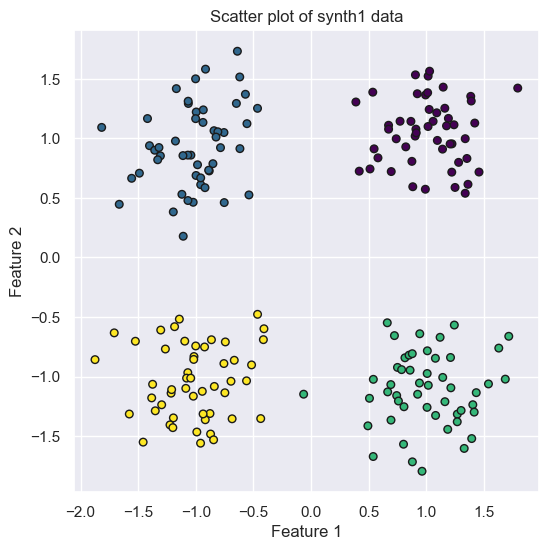

In [9]:
dataset_name = "synth1"

# Load the data
df = pd.read_csv(f"./data/{dataset_name}.csv")
X = df.drop(columns=['Class']).values
y = df['Class'].values

# Plot the data
fig = plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis', edgecolors='k')
plt.title(f'Scatter plot of {dataset_name} data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**Task 2.2:** Fit a $K=4$ component Gaussian mixture model to the data.

> *Hint:* To fit a Gaussian Mixture Model, use the class `GaussianMixture` from `sklearn.mixture`. As ususal, you will need two methods: `fit` and `predict`.

> *Hint:* When creating the `GaussianMixture` object you can e.g. specify number of clusters, covariance type (full/diagonal) and number of repetitions with different initial seeds. You can also define `tol` which is the convergence tolerance, i.e. when to stop the EM-algorithm from running.

> *Hint:* You can extract the fitted cluster means (centroids) by calling the method `means_` of the `GaussianMixture` class object.

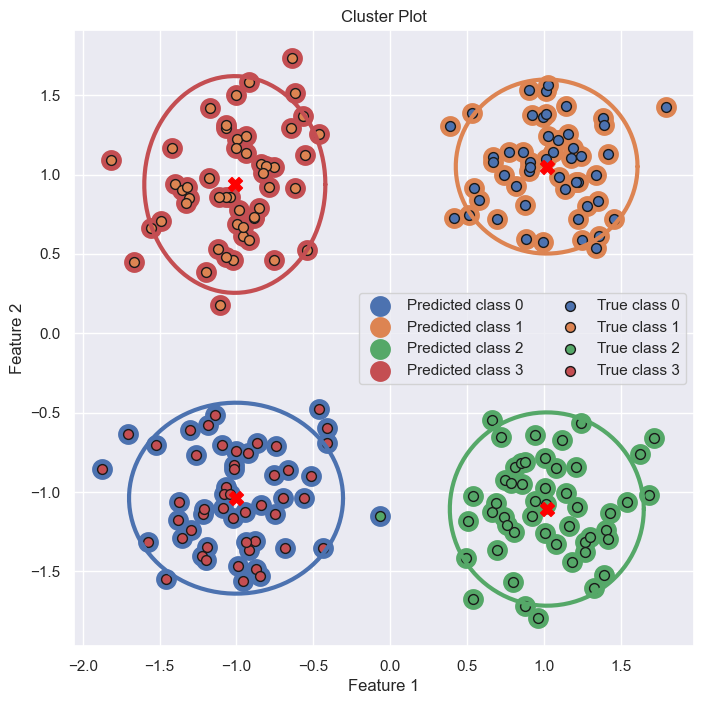

In [10]:
# Import GaussianMixture model from sklearn
from sklearn.mixture import GaussianMixture

# Define a suitable number of clusters
K = 4

# Define the hyperparameters for the GMM
cov_type = "diag"                   # covariance structure of the components, e.g. 'full' or 'diag'
initialization_method = "kmeans"    # initialization method for the centroids, e.g. 'random' or 'kmeans'
repetitions = 1                     # number of repetitions with different initializations, best result is kept
tol = 1e-6                          # convergence threshold for the EM algorithm

# Define the Gaussian mixture model
gmm = GaussianMixture(
    n_components=K,
    covariance_type=cov_type,
    n_init=repetitions,
    tol=tol,       # convergence threshold
    reg_covar=1e-6, # regularization to ensure positive definiteness
    init_params=initialization_method,
)

# Fit the model to the data and predict the cluster labels. Define this as pred_clusters
gmm.fit(X)
pred_clusters = gmm.predict(X)

# Extract cluster centroids (means of gaussians)
means = gmm.means_
# Extract cluster shapes (covariances of gaussians)
covariances = gmm.covariances_

# If you use 'diag', the covariances are given as vectors of diagonal elements
if cov_type.lower() == "diag": 
    # Convert diagonal elements to a matrix form
    covariances = np.array([np.diag(diagonal_elements) for diagonal_elements in covariances])

# Plot the clustering results
plt.figure(figsize=(8,8))
clusterplot(X, clusterid=pred_clusters, centroids=means, y=y.astype(int), covariances=covariances)
plt.show()

**Task 2.3:** What does it mean for the multivariate Gaussian mixture components if we set their covariance to be diagonal? How does this affect the generated clusters? What do you think might be benefits and drawbacks of restricting the covariance matrices?

> *Hint:* Try it out by changing the covariance type to `cov_type='diag'`.

**Full** means the components may independently adopt any position and shape.

**Tied** means they have the same shape, but the shape may be anything.

**Diagonal** means the contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components.

**Tied Diagonal** is a "tied" situation where the contour axes are oriented along the coordinate axes. (I have added this because initially it was how I misinterpreted "diagonal.")

**Spherical** is a "diagonal" situation with circular contours (spherical in higher dimensions, whence the name).

https://stats.stackexchange.com/questions/326671/different-covariance-types-for-gaussian-mixture-models

**Task 2.4:** Try to rerun the code several times using random initialization and the full covariance. What happens to the fitted clusters?

> *Hint:* Are the cluster indeces the same? Why is that not important?

*No. It is important because we might misclassify them.*

> *Hint:* Are the covariance structures for each cluster the same? Why is this an issue?

*With rep = 1 we get a lot of different structures. It is an issue because if shape depends on the initiation, we might get inconsistent results.* 

**Task 2.5:** Change the number of repetitions to $10$. How well does the GMM now fit the data? What happens now when you rerun the code? 

> *Hint:* The GMM fit is now more robust when rerunning the code. Can you explain why?

*Becuase we use 10 different random initialization sets of centroids. The malgorithm only returns one for which the clusters moved the least -> assuming they are closest to the truth.*


**Task 2.6:** What happens if you instead initialize the centroids of the mixture components by first running a $k$-means clustering on the data. What happens to the fit when initializing the centroids like this?  

> *Hint:* Using `initialization_method=random` means random initialization. Instead `initialization_method=kmeans` means that we first run a $k$-means and use the result as the starting point for the centroids. 

> *Hint:* $k$-means might converge faster/better than random, but might also cause the algorithm to be stuck in a poor local minimum.

*Seems that it converges to the 'truth' density function faster, even with repetition=1*

**Task 2.7:** In $k$-means based on Euclidean distance, observations are assigned to the centroids they are the closest to. Is this also the case when clustering by the Gaussian mixture model or is it possible that points are assigned a cluster that is further away than other clusters in terms of Euclidean distance?

> *Hint:* Can the scaling of the variables seriously affect the results we get when clustering by the GMM or is the model able to take the scaling of the data into account?

*The points are assigned based on the density around that coordinate. It means that they might bellong tothe different cluster as they would under euclidina distance. The model is very sensitive for the distances between points, becuase it affects their spread and correlation (covariance matrix). So if we want to scale variables we need to uniformly scale all the variables.*

**Task 2.8:** Which distance measure could we use for $k$-means to behave similarly to clustering with a Gaussian mixture model?

> *Hint:* Which distance measure takes the covariance structure into account? If you can not remember, check week 2 again.

*Mahalanobis distance → incorporates covariance, aligns with the true shape of the distribution.*

### Model selection for Gaussian mixture models

For supervised learning we used cross-validation to evaluate performance and estimate the number of parameters in our models. In last weeks exercise, we found that this approach could not be used in the $k$-means algorithm because both training and test error decrease monotonically with more clusters, so cross-validation cannot reveal an optimal number of clusters.

**Task 2.9**: What happens if we validate the number of clusters for Gaussian mixture model based on the EM algorithm using cross-validation, i.e., split the data into training and test data, train the model on the training data and evaluate how likely the test data points are based on the learned parameters, $\boldsymbol{w}$ and $\{\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)},\ldots,\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)} \}$ using the logarithm of the likelihood of the test data, 
$$
  \log{L}^{\mathrm{test}}=\sum_{i=1}^{N_{\mathrm{test}}}\log[p(\boldsymbol{x}_i^{(\mathrm{test})}|\boldsymbol{w},\{(\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)}),\ldots ,(\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)}) \})]
$$
as the performance metric?

> *Hint:* Remember, that in the GMM each cluster is represented by a mean vector and a covariance matrix. In one dimension, it is the well known bell-shaped probability distribution.

> *Hint:* If we have 100 data points and use 1 cluster, what would be the optimal solution for the GMM using the EM-algorithm? How well would this solution generalize to test data?

> *Hint:* If we have 100 data points and use 100 clusters, what would be the optimal solution? How well would this solution generalize?

> *Hint:* What if we use some intermediate number of clusters?

> *Hint:* It can be helpful to make an illustration by hand.

- *Answer:*

Apart from cross-validation the optimal number of clusters are sometimes derived by penalizing model complexity based on the Bayesian Information Criteria (BIC) or Akaike's Information Criteria (AIC). The two information criteria are defined by
$$
  \mathrm{BIC}=-2\log L+p\log(N),\qquad
  \mathrm{AIC}=-2\log L+2p
$$
where $p$ is the number of free parameters in the model, i.e., the total number of estimated variables in $\{\boldsymbol{w}, \boldsymbol{\mu}_{1}, \boldsymbol{\Sigma}_{1},\ldots,\boldsymbol{\mu}_{K}, \boldsymbol{\Sigma}_{K} \}$ whereas $N$ is the number of observations
and $\log L$ is the log likelihood of observing the data, i.e.,
$$
  \log L =\sum_{i=1}^N \log[p(\boldsymbol{x}_i|\boldsymbol{w},\{\boldsymbol{\mu}_{(1)},\boldsymbol{\Sigma}_{(1)},\ldots ,\boldsymbol{\mu}_{(K)},\boldsymbol{\Sigma}_{(K)} \}) ].
$$
The two information criteria define a trade-off between modeling the data well, i.e., minimize $-2\log L$, and penalizing complexity of the model, i.e., $p\log(N)$ and $2p$ respectively, such that the model with lowest AIC and BIC value indicates the model with best
trade-off. Note, that AIC and BIC do not require splitting the data in test and training sets, but are computed directly on the whole training data.

**Task 2.10:** Use BIC, AIC, and 10-fold crossvalidation to assess the best number of clusters for the synth1 data set. Use the script to compute the three measures for $K=1,\dots,10$, and use 10 replicates to avoid bad solutions due to poor initial conditions.
  
> *Hint:* The `GaussianMixture` class has `bic` and `aic` methods to compute BIC and AIC scores automatically. Access them by `gmm.bic`.

> *Hint:* As usual, use the module `sklearn.model_selection` to set up the crossvalidation folds.

> *Hint:* For cross-validation you can use the method `gmm.score` (after fitting the model) to evaluate the model fit on the test set in terms of log likelihood. To get negative log likelihood, do `CVE_fold = -gmm.score(X_test).sum()`. 

> *Hint:* You should compute the cross-validation as the sum of errors for all points in the data. Hence, you should add up the `CVE_fold` values computed in each fold. 

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4
Fitting model for K=5
Fitting model for K=6
Fitting model for K=7


C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=8


C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=9


C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fitting model for K=10


C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


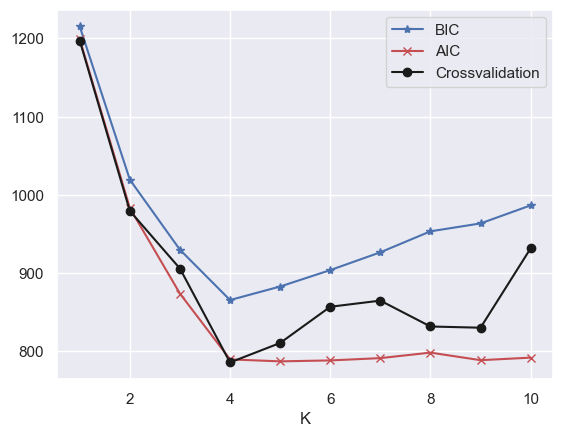

In [16]:
# The number of clusters to evaluate
hyperparameters = range(1, 11)

# Setup storage for the results
BIC = np.zeros((len(hyperparameters),))
AIC = np.zeros((len(hyperparameters),))
CVE = np.zeros((len(hyperparameters),))

# Define the hyperparameters for the GMM
cov_type = "full"                   # covariance structure of the components, e.g. 'full' or 'diag'
initialization_method = "kmeans"    # initialization method for the centroids, e.g. 'random' or 'kmeans'
repetitions = 10                    # number of repetitions with different initializations, best result is kept
tol = 1e-5                          # convergence threshold for the EM algorithm

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10, shuffle=True)

for i, K in enumerate(hyperparameters):
    print("Fitting model for K={0}".format(K))

    # Define and fit the Gaussian mixture model to the data (as in previous task)
    # Define the Gaussian mixture model
    gmm = GaussianMixture(
                    n_components=K,
                    covariance_type=cov_type,
                    n_init=repetitions,
                    tol=tol,       
                    reg_covar=1e-6, 
                    init_params=initialization_method,
                    )

    # Fit the model to the data. 
    gmm.fit(X)

    # Store BIC and AIC scores in the respective arrays
    BIC[i, ] = gmm.bic(X)
    AIC[i, ] = gmm.aic(X)
    
    # Run crossvalidation to compute the crossvalidation error (CVE) for the current number of clusters
    for train_index, test_index in CV.split(X):
        # extract training and test set for current CV fold
        X_train = X[train_index]
        X_test = X[test_index]

        # Define and fit the Gaussian mixture model to X_train (as in previous task)
        gmm = GaussianMixture(
                    n_components=K,
                    covariance_type=cov_type,
                    n_init=repetitions,
                    tol=tol,       
                    reg_covar=1e-6, 
                    init_params=initialization_method,
                    )
        gmm.fit(X_train)
     
        # Compute and store negative log likelihood of X_test
        CVE[i] += -gmm.score_samples(X_test).sum()
        

# Plot results
plt.figure(1)
plt.plot(hyperparameters, BIC, "-*b")
plt.plot(hyperparameters, AIC, "-xr")
plt.plot(hyperparameters, 2 * CVE, "-ok")
plt.legend(["BIC", "AIC", "Crossvalidation"])
plt.xlabel("K")
plt.show()

**Task 2.11:** Which of the two information criteria BIC and AIC will in general penalize model complexity the most? What are the benefits and drawbacks of AIC and BIC versus cross-validation?

- *Answer:*

BIC penalizes model complexity more strongly than AIC in most practical situations.
- AIC is more forgiving → tends to select more complex models.
- BIC is stricter → favors simpler models, especially as sample size grows.

🔹 **AIC**

*Benefits:*
- Good for predictive accuracy.
- More likely to capture subtle structure (less harsh penalty).

*Drawbacks:*
- Can overfit by selecting overly complex models.
- Doesn’t explicitly account for sample size.

🔹 **BIC**

*Benefits:*
- Consistent: as n\rightarrow \infty , BIC tends to select the true model (if it’s among candidates).
- Stronger guard against overfitting.

*Drawbacks:*
- May underfit with small datasets (penalty too strong).
- Less focused on predictive accuracy, more on parsimony.

🔹 **Cross-Validation (CV)**

*Benefits:*
- Directly estimates out-of-sample predictive performance.
- Flexible: works for many model types, not just likelihood-based.
- Often considered the “gold standard” for predictive modeling.

*Drawbacks:*
- Computationally expensive (especially with large datasets or complex models).
- Results can vary depending on folds and random splits.
- Less tied to formal statistical theory of consistency.




---
## Part 3: Density estimation

We will apart from the Gaussian mixture model we just used now consider the two other approaches to density estimation, namely kernel density estimation (KDE), and $k$-nearest neighbors density estimation.

Kernel density estimation is a non-parametric method of estimating the probability density function of a random variable. Inference about the population is made, based on a finite data sample. The estimated kernel density for a variable $x$ is given by 
$$
  f(x)=\frac{1}{N}\sum_{i=1}^N K(x-x_i)
$$
where $K$ is the kernel function that must integrate to one, $N$ is the sample size, and $f(x)$ is the estimated density.

We will presently consider density estimation based on the kernel formed by the normal distribution, i.e., 
$$
  K(x-x_i) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\Big(-\frac{(x-x_i)^2}{2\sigma^2}\Big).
$$
Notice, that for this choice of kernel function the kernel density estimation can be considered a Gaussian mixture model where the number of clusters is the same as the number of observations, i.e., there is a Gaussian around each observation, while the mixing coefficient is fixed to be the same for all classes, $w_n=1/N$.


**Task 3.1:** Construct an artificially generated one-dimensional data set with $N=1000$ observations from a mixture of three Gaussians defined as follows
$$
\begin{align}
  p(x) = \frac{1}{3}{\cal N}(x|1,1) + \frac{1}{3}{\cal N}(x|3,0.25) +
  \frac{1}{3}{\cal N}(x|6,4) \ .
\end{align}
$$

> *Hint:* You can generate data from the Gaussian mixture model in the following way: First, you choose one of the components by random according to the mixture coefficients. Then, you generate the data according to the Gaussian distribution for the chosen component.

> *Hint:* Type `help(np.random.multinomial)` to learn how to generate a random variable from a discrete distribution.

> *Hint:* Remember that the parameters of the univariate normal distribution are the mean and variance.

> *Hint:* Use `np.random.normal` that we also saw in previous weeks. Does it take the standard deviation or variance as input? Use `help(np.random.normal)` to find out!

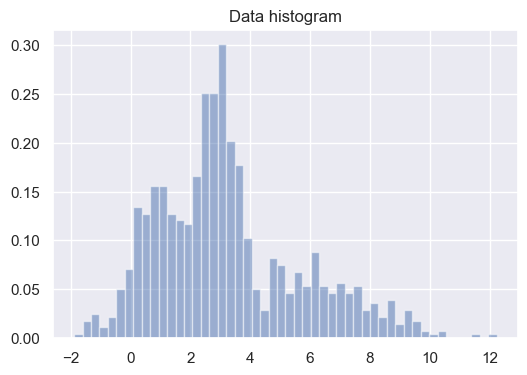

In [23]:
# Number of data objects
N = 1000
# Number of attributes
M = 1

# Define mean and standard deviations in two arrays
mus = np.array([1, 3, 6])
sigmas = np.array([1, 0.5, 2])

# Define component_sizes, which is the number of samples to draw from each mixture component using np.random.multinomial
component_sizes = np.random.multinomial(N, [1/3, 1/3, 1/3])

# Allocate variable for data
X = np.empty((N, M))
for component_idx in range(len(component_sizes)):

    # Extract parameters for current component
    mu = mus[component_idx]
    sigma = sigmas[component_idx]
    N_component = component_sizes[component_idx]

    # Compute start and end indices for storing samples from current component
    start_idx = component_sizes.cumsum()[component_idx] - N_component
    end_idx = component_sizes.cumsum()[component_idx]

    # Draw samples from the current component and store in X at the correct indices
    X[start_idx:end_idx, :] = np.random.normal(mu, sigma, (N_component, M))

# Plot histogram of sampled data
plt.figure(figsize=(6,4))
plt.hist(X, bins=50, density=True, alpha=0.5)
plt.title("Data histogram")
plt.show()

**Task 3.2:** Can you identify each component of the mixture in the plot and its associated parameters (mean, variance, mixture coefficient?)

**Task 3.3:**  Estimate the density using a kernel density estimator with a Gaussian kernel and a kernel width of 1. Plot the density on the range $-10$ to $10$ and compare the result to the histogram.

> *Hint:* Use `gaussian_kde` from the module `scipy.stats` to fit a kernel density estimator.

> *Hint:* To define at which $x$-values the KDE should be evaluated, you can define a vector of values and pass it to the `evaluate` method of the fitted KDE estimator.

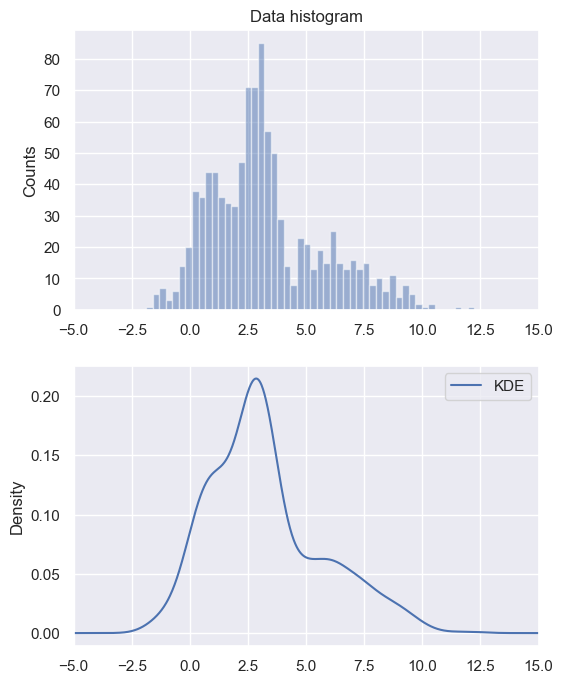

In [26]:
from scipy.stats import gaussian_kde

# Compute kernel density estimate
kde = gaussian_kde(X.ravel(), bw_method='scott')

# Define x values where the KDE should be evaluated
x = np.linspace(-5, 15, 1000)

# Plot histogram of sampled data
fig, axs = plt.subplots(2, 1, figsize=(6,8))
axs[0].hist(X, bins=50, density=False, alpha=0.5)
axs[0].set_title("Data histogram")
axs[0].set_xlim(-5, 15)
axs[0].set_ylabel("Counts")

# Evaluate the KDE in the defined x values and plot it in axs[1]
axs[1].plot(x, kde.evaluate(x), label='KDE')

axs[1].set_ylabel("Density")
axs[1].set_xlim(-5, 15)
axs[1].legend()
plt.show()

**Task 3.4:** Try varying the kernel width in the KDE. How could you select an optimal kernel width?

> *Hint:* The kernel width is defined by the `bw_method` argument.

Consider the following measure of density of the $i^{th}$ observation $\boldsymbol{x}_i$ given based on its $k$-nearest neighbors:
$$
    \textrm{density}_{\boldsymbol{X}_{\setminus i} }(\boldsymbol{x}_i, K) = \frac{1}{ \frac{1}{K} \sum_{\boldsymbol{x}' \in N_{\boldsymbol{X}_{\setminus i} }(\boldsymbol{x}_i, K)} d(\boldsymbol{x}_i, \boldsymbol{x}') },
$$
where $N_{\boldsymbol{X}}(\boldsymbol{x}, K)$ is the $K$ observations in $\boldsymbol{X}$ which are nearest to $\boldsymbol{x}$, and $\boldsymbol{X}_{\setminus i}$ is simply $\boldsymbol{X}$ with observation $i$ removed, i.e.
$$
  \boldsymbol{X}_{\setminus i}^T  = \begin{bmatrix} \boldsymbol{x}_1 & \boldsymbol{x}_2 & \cdots \boldsymbol{x}_{i-2} & \boldsymbol{x}_{i-1} & \boldsymbol{x}_{i+1}& \boldsymbol{x}_{i+2} & \cdots & \boldsymbol{x}_{N} \end{bmatrix}.
$$
This estimates the density as the inverse of the average distance to the $k$ nearest neighbors.

If the dataset contains regions of varying densities it can be useful to define a notion of density that is relative to the neighborhood of the object. The following average relative density is one such approach
$$
  \textrm{ard}_{\boldsymbol{X}}(\boldsymbol{x}_i, K) = \frac{\textrm{density}_{\boldsymbol{X}_{\setminus i} }(\boldsymbol{x}_i, K)}{\frac{1}{K}\sum_{\boldsymbol{x}_j \in N_{\boldsymbol{X}_{\setminus i} }(\boldsymbol{x}_i, K)} \textrm{density}_{\boldsymbol{X}_{\setminus j} }(\boldsymbol{x}_j, K) }.
$$

**Task 3.5:** Estimate the density using equation kNNdensity as well as the average relative density with the 200-nearest neighbors based on the Euclidean distance measure. Plot the density on the range $-10$ to $10$. Compare your results to the three previous exercises.

> *Hint:* To find the nearest neighbors and the distances needed to compute the first equation, you can fit the `NearestNeighbors` model from the module `sklearn.neighbors` and then use the method `kneighbors()` of to extract nearest neighbors distances.

> *Hint:* You can get a distance matrix to the $k$ nearest neighbors as `D, i = knn.kneighbors(np.expand_dims(x, axis=-1))`. Then you can get the KNN density by `knn_density = 1.0 / (D[:, 1:].sum(axis=1) / K)`.

> *Hint:* What is the equivalent for the average relative density estimate?

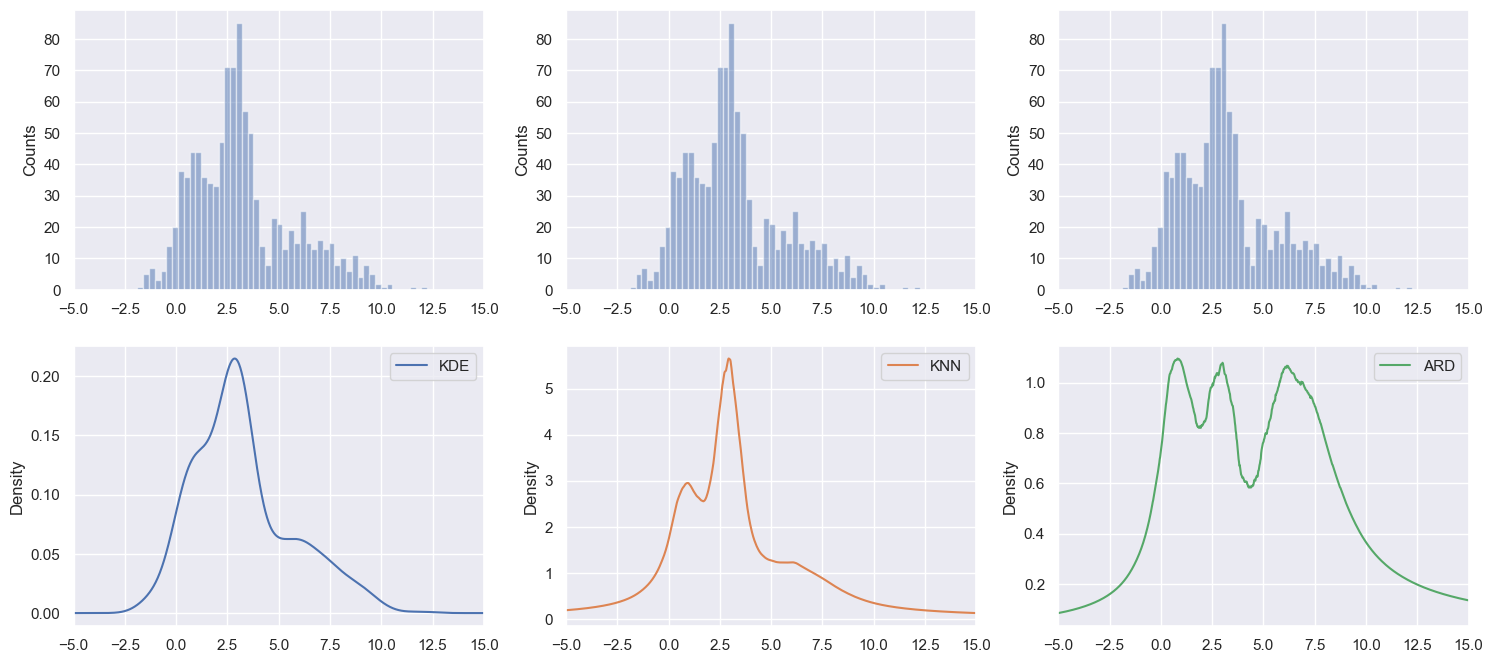

In [27]:
from sklearn.neighbors import NearestNeighbors

# Number of neighbors
K = 200

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)

# Compute the density using the kNN density estimate
### BEGIN SOLUTION
D, i = knn.kneighbors(np.expand_dims(x, axis=-1))  # note expand_dims is simple to make it (100,1) and not (100,) array
knn_density = 1.0 / (D[:, 1:].sum(axis=1) / K)
### END SOLUTION

# Compute the average relative density
### BEGIN SOLUTION
DX, iX = knn.kneighbors(X)
knn_densityX = 1.0 / (DX[:, 1:].sum(axis=1) / K)
knn_avg_rel_density = knn_density / (knn_densityX[i[:, 1:]].sum(axis=1) / K)
### END SOLUTION

# Plot histograms and density estimates
fig, axs = plt.subplots(2, 3, figsize=(18,8))
for i, density_estimate in enumerate([kde.evaluate(x), knn_density, knn_avg_rel_density]):

    axs[0, i].hist(X, bins=50, density=False, alpha=0.5)
    axs[0, i].set_ylabel("Counts")
    axs[0, i].set_xlim(-5, 15)

    axs[1, i].plot(x, density_estimate, color=f'C{i}', label='KDE' if i==0 else 'KNN' if i==1 else 'ARD')
    axs[1, i].set_ylabel("Density")
    axs[1, i].set_xlim(-5, 15)
    axs[1, i].legend()

plt.show()

**Task 3.6:** Try different values for the number of neighbors. What happens to the density estimates?

<br>


---
## Part 4: Outlier detection

The following two definitions of an outlier are common:

- **Hawkin's Definition of an Outlier:** An outlier is an observation that differs so much from other observations as to arouse suspicion that it was generated by a different mechanism.
- **Probabilistic Definition of an Outlier:** An outlier is an object that has a low probability with respect to a probability distribution model of the data.

Thus, in order to detect outliers we need a mechanism that can establish whether an observation differs so much from other observations as to be deemed an outlier. An important tool to evaluate
this is to create a model of the data density and then evaluate how likely the observations are given the density.

**Task 4.1:**  Add an outliner at $x=-10$ to the data.

> *Hint:* E.g. do it like `X[-1,0]=-10`.

In [28]:
# Add an outlier to the data
X[-1, 0] = -10

**Task 4.2:** Use a Gaussian kernel density estimator to determine if the new point is an outlier. Verify that the outlier you have introduced has the lowest density. Try different values of the kernel width. What happens when the kernel width is too large / too small?

> *Hint:* Fit a kernel density estimate to the data. Then estimate the density at the $x$-values in the data set.

> *Hint:* Sort the data according to the density estimate and find the index of the lowest density object. Does this correspond to where you added the outlier to the data matrix?

> *Hint:* To find the indices and values of the lowest-density points, you can use the methods `argsort()` and `sort()` respectively, on the output from the `evaluate()` method.


The index of the lowest density object: 999
The observation corresponding to the lowest density score: x=[-10.]
The lowest density score: 0.0006458932655578402


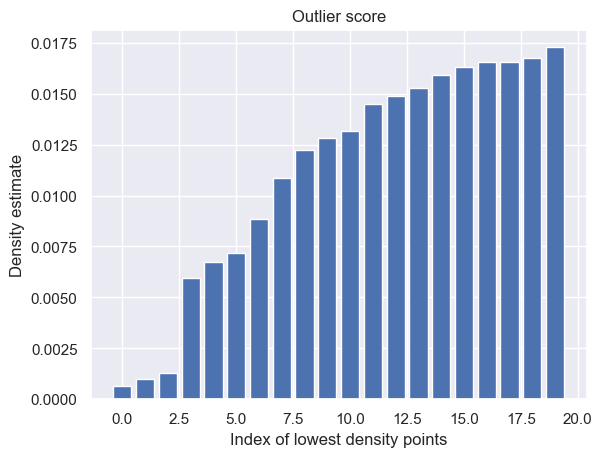

In [29]:
# Fit a kernel density estimate to the data. Sort the data according to the density estimate and find the index of the lowest density object
# Compute kernel density estimate
kde = gaussian_kde(X.ravel())

# Compute the density scores for each object in the dataset
densities = kde.evaluate(X.ravel())

# Sort the scores and get the indices
idx = densities.argsort()
densities.sort()

print("The index of the lowest density object: {0}".format(idx[0]))
print("The observation corresponding to the lowest density score: x={0}".format(X[idx[0], :]))
print("The lowest density score: {0}".format(densities[0]))

# Plot kernel density estimate
plt.figure()
plt.bar(range(20), densities[:20])
plt.title("Outlier score")
plt.xlabel("Index of lowest density points")
plt.ylabel("Density estimate")
plt.show()


In the code cell below, we use the function `gaussKernelDensity()` that implements density estimation by the gaussian kernel density estimator using a very efficient implementation of leave-one-out cross-validation. I.e. the density of each observation is estimated from all other observations not including the observation itself in the estimate. We demonstrate how to use it to estimate the optimal kernel width by evaluating the estimated densities for a range of different kernel widths and plot the leave-one-out density of the 20 lowest-density points in a bar plot.

**Task 4.3:** Inspect the code and see how the `gaussKernelDensity` is used.
> *Hint:* To get the leave-one-out KDE for each data object in the data set for a kernel width of 5, we can use the command `f, log_f = gaussKernelDensity(X, 5)`.
> *Hint:* The log-density for all observations is given by `logP = log_f.sum()`. The optimal kernel width is the width with highest `logP`.
> *Hint:* To find the 20 lowest-density points, we again use the function `sort` to sort the output `densities`.

C:\Users\mrusn\AppData\Local\Temp\ipykernel_12640\1349555762.py:27: RuntimeWarning: divide by zero encountered in log
  log_density = -np.log(N - 1) - M / 2 * np.log(2 * np.pi * width) + np.log(sQ)


Optimal estimated width is: 1.0
Lowest density: 2.3804174545843386e-18 for data object: 999


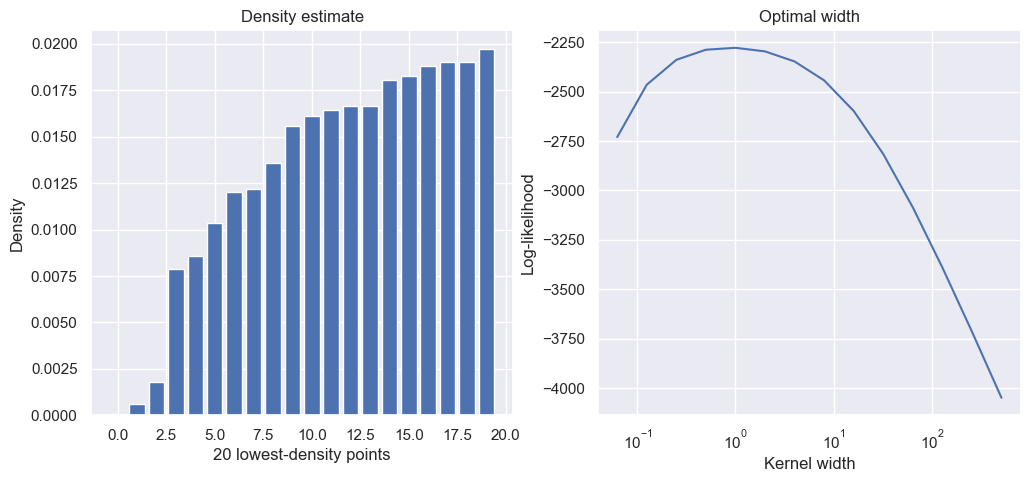

In [30]:
def gaussKernelDensity(X, width):
    """
    GAUSKERNELDENSITY Calculate efficiently leave-one-out Gaussian Kernel Density estimate
    Input:
        X        N x M data matrix
        width    variance of the Gaussian kernel

    Output:
        density        vector of estimated densities
        log_density    vector of estimated log_densities
    """
    X = np.asmatrix(np.asarray(X))
    N, M = X.shape

    # Calculate squared euclidean distance between data points
    # given by ||x_i-x_j||_F^2=||x_i||_F^2-2x_i^Tx_j+||x_i||_F^2 efficiently
    x2 = np.square(X).sum(axis=1)
    D = x2[:, [0] * N] - 2 * X.dot(X.T) + x2[:, [0] * N].T

    # Evaluate densities to each observation
    Q = np.exp(-1 / (2.0 * width) * D)
    # do not take density generated from the data point itself into account
    Q[np.diag_indices_from(Q)] = 0
    sQ = Q.sum(axis=1)

    density = 1 / ((N - 1) * np.sqrt(2 * np.pi * width) ** M + 1e-100) * sQ
    log_density = -np.log(N - 1) - M / 2 * np.log(2 * np.pi * width) + np.log(sQ)
    return np.asarray(density), np.asarray(log_density)


# Estimate the optimal kernel density width, by leave-one-out cross-validation
kernel_widths = 2.0 ** np.arange(-10, 10)

# Setup storage for the log-likelihoods
logP = np.zeros(np.size(kernel_widths))
for i, w in enumerate(kernel_widths):
    f, log_f = gaussKernelDensity(X, w)
    logP[i] = log_f.sum()

# Find the optimal width
best_logP = logP.max()
best_logP_idx = logP.argmax()
optimal_width = kernel_widths[best_logP_idx]
print("Optimal estimated width is: {0}".format(optimal_width))

# Estimate density for each observation not including the observation itself in the density estimate
densities, log_densities = gaussKernelDensity(X, optimal_width)
densities = densities.flatten()

# Sort the scores and get the indices
sorted_idxs = densities.argsort()
densities.sort()

# Display the index of the lowest density data object
print("Lowest density: {0} for data object: {1}".format(densities[0], sorted_idxs[0]))

# Plot density estimate of outlier score
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(range(20), densities[:20].reshape(-1,),)
axs[0].set_title("Density estimate")
axs[0].set_ylabel("Density")
axs[0].set_xlabel("20 lowest-density points")

axs[1].semilogx(kernel_widths, logP)
axs[1].set_title("Optimal width")
axs[1].set_xlabel("Kernel width")
axs[1].set_ylabel("Log-likelihood")
plt.show()


---
## Part 5: Outlier detection on hand written digits

We will in this part of the exercise investigate if some of the hand written digits of each class can be considered outliers. To do this, we first load the digits data set. We restrict the analysis to digit of the number "2".

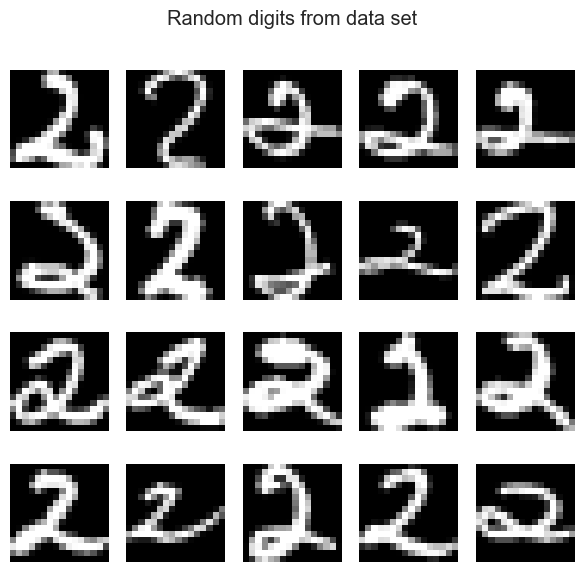

In [31]:
selected_digit = 2

# Load the digits data set
data = np.load("data/digits.npy")
X = data[:, :-1]
y = data[:, -1]

# Restrict the data set to only the digit of interest
X = X[y == selected_digit, :]
N, M = X.shape

# Plot random digits (the first 20 in the data set), for comparison
nrows, ncols = 4, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 6), squeeze=False, tight_layout=True)
for i in range(nrows*ncols):
    axs[i // ncols, i % ncols].imshow(X[i, :].reshape(16, 16), cmap='gray')
    axs[i // ncols, i % ncols].axis('off')
    axs[i // ncols, i % ncols].axis('off')
fig.suptitle("Random digits from data set")
plt.show()

**Task 5.1:** Detect observations of the selected digit that are outliers. Make a bar plot of the densities of the 20 lowest-density data objects in the data set and also plot them as images. Use:

  1) Gaussian kernel density estimation to determine outliers. Specifically, use the function `gaussKernelDensity()` to first estimate the optimal kernel width using cross-validation.

  2) the KNN density estimation method based on the Euclidean distance measure and using $K=5$ neighbors.

  3) the KNN average relative density estimation method, also based on the Euclidean distance measure and using $K=5$ neighbors.

> *Hint:* Basically, you have to stitch together parts of the previous code. If you get stuck, take a look at the solution.

> *Hint:* Can you identify any data objects that really are outliers? Do the three methods agree?

> *Hint:* In what sense are the low-density 2's different from the randomly chosen ones?

<br>

**Task 5.2:** Try other digits than "2". Does the method in general identify digits that are outliers?

C:\Users\mrusn\AppData\Local\Temp\ipykernel_12640\1349555762.py:27: RuntimeWarning: divide by zero encountered in log
  log_density = -np.log(N - 1) - M / 2 * np.log(2 * np.pi * width) + np.log(sQ)


Optimal estimated width is: 0.19422718071215705
Lowest density: 7.708603621422687e-285 for data object: 926


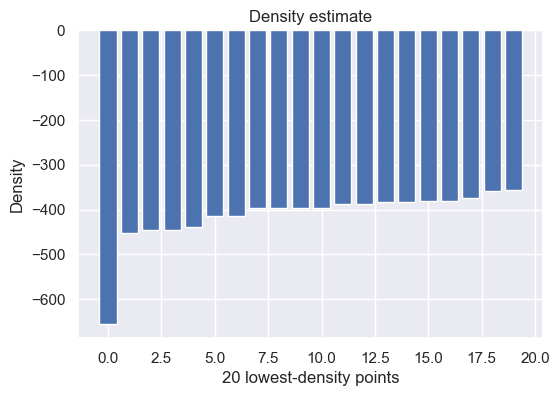

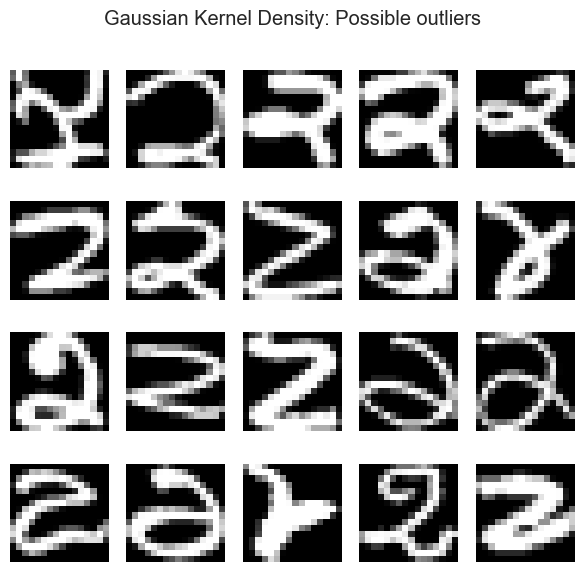

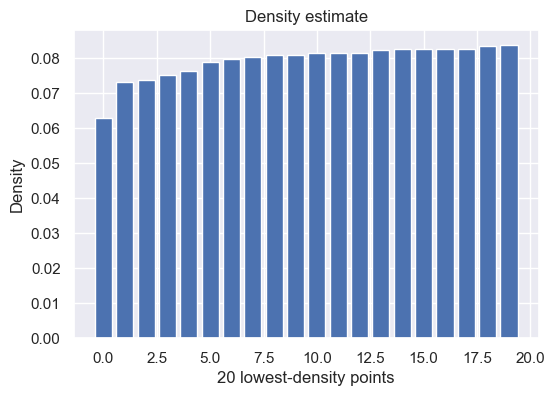

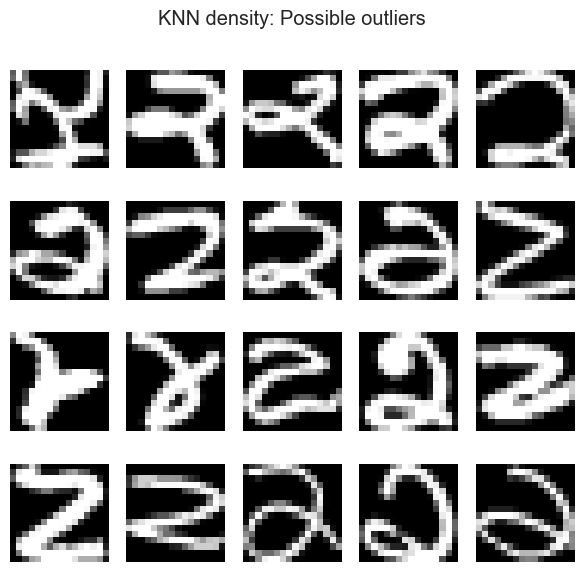

KeyboardInterrupt: 

In [32]:
## Gaussian Kernel Density ##

# Estimate the optimal kernel density width, by leave-one-out cross-validation
kernel_widths = X.var(axis=0).max() * (2.0 ** np.arange(-10, 3))

# Setup storage for the log-likelihoods
logP = np.zeros(np.size(kernel_widths))
for i, w in enumerate(kernel_widths):
    f, log_f = gaussKernelDensity(X, w)
    logP[i] = log_f.sum()

# Find the optimal width
best_logP = logP.max()
best_logP_idx = logP.argmax()
optimal_width = kernel_widths[best_logP_idx]
print("Optimal estimated width is: {0}".format(optimal_width))

# Estimate density for each observation not including the observation itself in the density estimate
densities, log_densities = gaussKernelDensity(X, optimal_width)
densities = densities.flatten()

# Sort the scores and get the indices
sorted_idxs = densities.argsort()
densities.sort()

# Display the index of the lowest density data object
print("Lowest density: {0} for data object: {1}".format(densities[0], sorted_idxs[0]))


# Plot density estimate of outlier score
fig = plt.figure(figsize=(6, 4))
plt.bar(range(20), np.log(densities)[:20])
plt.title("Density estimate")
plt.ylabel("Density")
plt.xlabel("20 lowest-density points")
plt.show()

# Plot random digits (the first 20 in the data set), for comparison
nrows, ncols = 4, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 6), squeeze=False, tight_layout=True)
for i in range(nrows*ncols):
    axs[i // ncols, i % ncols].imshow(X[sorted_idxs[i], :].reshape(16, 16), cmap='gray')
    axs[i // ncols, i % ncols].axis('off')
    axs[i // ncols, i % ncols].axis('off')
    
fig.suptitle("Gaussian Kernel Density: Possible outliers")
plt.show()


## KNN Density ##

K = 5
knn = NearestNeighbors(n_neighbors=K + 1).fit(X)

def density(X, i):
    """
    Compute density at observation i in X using LOO.
    Note this code can easily be vectorized for speed
    """
    D, _ = knn.kneighbors(np.expand_dims(X[i], axis=0))
    # don't compute distance to observation itself.
    density = 1.0 / D[:, 1:].mean(axis=1)
    return density

# Compute density for each observation
densities = np.concatenate([density(X, i) for i in range(N)])

# Sort the scores and get the indices
sorted_idxs = densities.argsort()
densities.sort()

# Plot density estimate of outlier score
fig = plt.figure(figsize=(6, 4))
plt.bar(range(20), densities[:20])
plt.title("Density estimate")
plt.ylabel("Density")
plt.xlabel("20 lowest-density points")
plt.show()

# Plot random digits (the first 20 in the data set), for comparison
nrows, ncols = 4, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 6), squeeze=False, tight_layout=True)
for i in range(nrows*ncols):
    axs[i // ncols, i % ncols].imshow(X[sorted_idxs[i], :].reshape(16, 16), cmap='gray')
    axs[i // ncols, i % ncols].axis('off')
    axs[i // ncols, i % ncols].axis('off')
fig.suptitle("KNN density: Possible outliers")
plt.show()


## Average Relative Density ##

# Compute the average relative density
def ard(X, i):
    _, J = knn.kneighbors(np.expand_dims(X[i], axis=0))
    J = J[0, 1:]  # don't include i itself.
    return density(X, i) / np.mean([density(X, j) for j in J])


densities = np.concatenate([ard(X, i) for i in range(N)])

# Sort the scores and get the indices
sorted_idxs = densities.argsort()
densities.sort()

# Plot density estimate of outlier score
fig = plt.figure(figsize=(6, 4))
plt.bar(range(20), densities[:20])
plt.title("Density estimate")
plt.ylabel("Density")
plt.xlabel("20 lowest-density points")
plt.show()

# Plot random digits (the first 20 in the data set), for comparison
nrows, ncols = 4, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 6), squeeze=False, tight_layout=True)
for i in range(nrows*ncols):
    axs[i // ncols, i % ncols].imshow(X[sorted_idxs[i], :].reshape(16, 16), cmap='gray')
    axs[i // ncols, i % ncols].axis('off')
    axs[i // ncols, i % ncols].axis('off')
fig.suptitle("KNN average relative density: Possible outliers")
plt.show()